In [1]:
using BenchmarkTools
using GeodesicIntegration
using Plots; pyplot();

Firstly, use a simple test case to verify that the module works as intended. The Schwarzschild metric predicts a stable circular orbit at $\ell/M=\sqrt{12}$ for timelike objects, which refers to 

$$r_{\text{ISCO}} = 6M$$

This is a good test case for the algorithm.

In [2]:
# Init
M = 5.0

scmetric = SchwarzschildMetric(M);

In [3]:
# Initial position
init_x = [0.0, 6.0M, π/2, 0.0];

# Initial 3-velocity; the time component is determined from normalization of 4-velocity
l = M*√12
init_u = [0.0, 0.0, l / evaluate(scmetric, init_x)[1][4, 4]];

# Set up the problem to be integrated -- uses geodesic equation in 4-geometry
problem = DirectGeodesicProblem(scmetric)

# Configure the integrator with the initial conditions and range
# Scaffolding returns total set of initial conditions for manifold projection callbacks
τspan      = (0.0, 400.0)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)

ε = killing_e(scmetric, init_x, X0[5:8])

# Assert energy and angular momentum conservation via manifold projection callback
# Maintain the normalization of the 4-velocity
function g(r, u, p, t)
    r[1] = 0; r[2] = 0; r[3] = 0; r[4] = 0;
    r[5] = @. ((1 - (2M / u[2])) * u[5]) - ε
    r[6] = 0; r[7] = 0;
    r[8] = @. u[2]*u[2]*sin(u[3])*sin(u[3])*u[8] - l
end

cb = ManifoldProjection(g)

# Run
sol = solve(diffeq, reltol=1e-10, dense=true, save=true, callback=cb)

retcode: Success
Interpolation: 3rd order Hermite
t: 9-element Array{Float64,1}:
   0.0     
   0.139494
   0.75519 
   3.17638 
  11.736   
  39.1682  
 119.495   
 339.807   
 400.0     
u: 9-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.41421, 0.0, 0.0, 0.019245]                            
 [0.197274, 30.0, 1.5708, 0.00268456, 1.41421, 2.41983e-19, 1.58176e-21, 0.019245]
 [1.068, 30.0, 1.5708, 0.0145336, 1.41421, 1.31005e-18, 8.56334e-21, 0.019245]    
 [4.49209, 30.0, 1.5708, 0.0611295, 1.41421, 5.51015e-18, 3.6018e-20, 0.019245]   
 [16.5972, 30.0, 1.5708, 0.225859, 1.41421, 2.03587e-17, 1.33078e-19, 0.019245]   
 [55.3922, 30.0, 1.5708, 0.753793, 1.41421, 6.7946e-17, 4.44141e-19, 0.019245]    
 [168.991, 30.0, 1.5708, 2.29968, 1.41421, 2.26589e-17, 1.35499e-18, 0.019245]    
 [480.56, 30.0, 1.5708, 6.53959, 1.41421, 3.98888e-16, -2.31489e-18, 0.019245]    
 [565.685, 30.0, 1.5708, 7.698, 1.41421, 4.37433e-16, -3.18769e-18, 0.019245]     

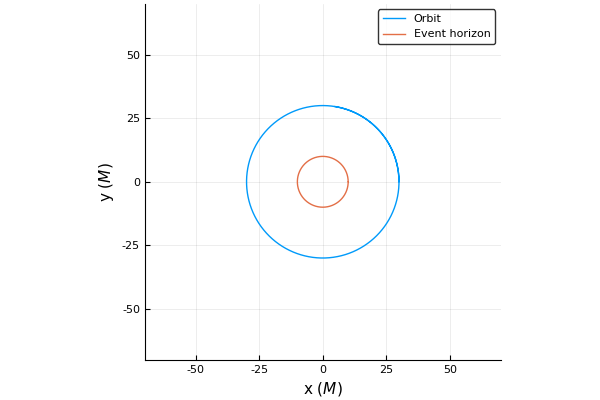

In [4]:
const N  = 10
T  = τspan[2]
ts = linspace(0, τspan[2], N*T)

plot(sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*cos.(sol(ts, idxs=4)), 
    sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*sin.(sol(ts, idxs=4)), 
    aspect_ratio=1, label="Orbit")
ϕ = linspace(0, 2π, 1000)
plot!(2M*cos.(ϕ), 2M*sin.(ϕ), label="Event horizon", xlims=(-70, 70), ylims=(-70, 70))
xlabel!("x (\$M\$)")
ylabel!("y (\$M\$)")

The integration produces a beautiful circular orbit! Now to verify the residues from the theory: 

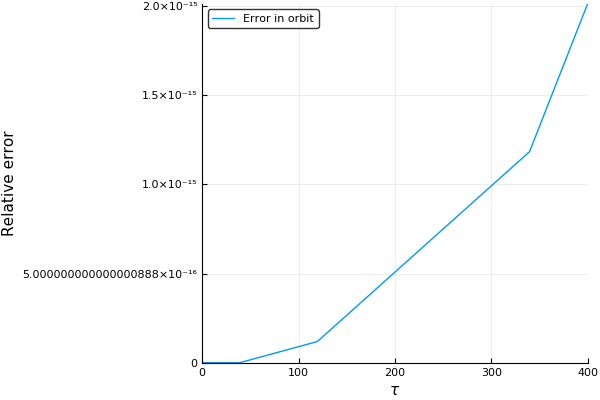

In [5]:
plot(sol.t, (sol[2, :] - 6M)/(6M), label="Error in orbit")
xlabel!("\$\\tau\$"); ylabel!("Relative error")

The differences are within numerical uncertainty! Let's run the simulation for a long time and check how the manifold projection technique preserves our conserved quantities $\varepsilon$ and $\ell$:

In [6]:
τspan      = (0.0, 1e8)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)
sol        = solve(diffeq, reltol=1e-10, dense=true, save=true, callback=cb)

retcode: Success
Interpolation: 3rd order Hermite
t: 2642-element Array{Float64,1}:
    0.0      
    0.139494 
    0.75519  
    3.17638  
   11.736    
   39.1682   
  119.495    
  339.807    
  854.731    
 1754.23     
 2080.12     
 2336.46     
 2650.17     
    ⋮        
    7.56942e7
    7.66837e7
    7.78312e7
    7.94195e7
    8.11354e7
    8.30299e7
    8.51969e7
    8.77055e7
    9.05017e7
    9.37442e7
    9.72288e7
    1.0e8    
u: 2642-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.41421, 0.0, 0.0, 0.019245]                                 
 [0.197274, 30.0, 1.5708, 0.00268456, 1.41421, 2.41983e-19, 1.58176e-21, 0.019245]     
 [1.068, 30.0, 1.5708, 0.0145336, 1.41421, 1.31005e-18, 8.56334e-21, 0.019245]         
 [4.49209, 30.0, 1.5708, 0.0611295, 1.41421, 5.51015e-18, 3.6018e-20, 0.019245]        
 [16.5972, 30.0, 1.5708, 0.225859, 1.41421, 2.03587e-17, 1.33078e-19, 0.019245]        
 [55.3922, 30.0, 1.5708, 0.753793, 1.41421, 6.7946e-17, 4.44141e-19, 

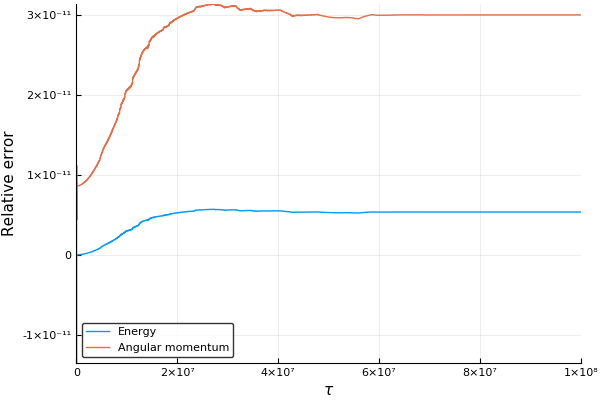

In [7]:
plot(sol.t, ((1 - (2M ./ sol[2, :])) .* sol[5, :] - ε)/ε, label="Energy")
plot!(sol.t, ((sol[2, :].^2 .* sin.(sol[3, :]).^2 .* sol[8, :]) - l)/l, label="Angular momentum")
xlabel!("\$\\tau\$"); ylabel!("Relative error")

What happens when we slightly increase the angular momentum?

In [8]:
l = M*√12 + .01M
init_u = [0.0, 0.0, l / evaluate(scmetric, init_x)[1][4, 4]];

τspan      = (0.0, 4000.0)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)

# Short timespan, so no need for manifold projection
sol = solve(diffeq, reltol=1e-10, dense=true)

retcode: Success
Interpolation: 3rd order Hermite
t: 47-element Array{Float64,1}:
    0.0     
    0.139482
    0.690125
    3.03392 
   10.5066  
   34.0716  
   93.5794  
  165.709   
  236.714   
  317.174   
  408.791   
  489.489   
  580.861   
    ⋮       
 2875.19    
 2975.69    
 3077.14    
 3185.58    
 3284.5     
 3400.0     
 3495.3     
 3606.67    
 3706.4     
 3816.21    
 3919.4     
 4000.0     
u: 47-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.41524, 0.0, 0.0, 0.0193006]                            
 [0.1974, 30.0, 1.5708, 0.00269209, 1.41524, 4.48036e-6, 1.59078e-21, 0.0193006]   
 [0.976689, 30.0, 1.5708, 0.0133198, 1.41524, 2.21677e-5, 7.87079e-21, 0.0193006]  
 [4.2937, 30.0001, 1.5708, 0.0585561, 1.41523, 9.7453e-5, 3.4601e-20, 0.0193004]   
 [14.8692, 30.0018, 1.5708, 0.202776, 1.41519, 0.000337473, 1.19808e-19, 0.0192983]
 [48.2143, 30.0186, 1.5708, 0.657328, 1.4148, 0.00109396, 3.87939e-19, 0.0192766]  
 [132.334, 30.1404, 1.5708, 1.80052

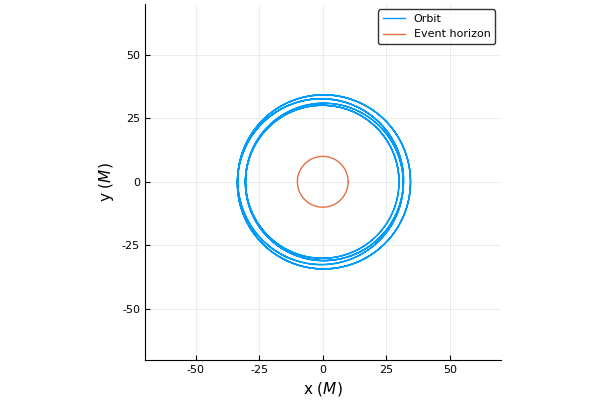

In [9]:
T  = τspan[2]
ts = linspace(0, τspan[2], N*T)

plot(sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*cos.(sol(ts, idxs=4)), 
    sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*sin.(sol(ts, idxs=4)), 
    aspect_ratio=1, label="Orbit")
ϕ = linspace(0, 2π, 1000)
plot!(2M*cos.(ϕ), 2M*sin.(ϕ), label="Event horizon", xlims=(-70, 70), ylims=(-70, 70))
xlabel!("x (\$M\$)")
ylabel!("y (\$M\$)")

The orbit begins to oscillate radially back and forth, as expected. If we choose an angular momentum increase that's of order the ISCO angular momentum:

In [10]:
l = M*√12 + .5M
init_u = [0.0, 0.0, l / evaluate(scmetric, init_x)[1][4, 4]];

τspan      = (0.0, 25000.0)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)

# Short timespan, so no need for manifold projection
sol = solve(diffeq, reltol=1e-10, dense=true)

retcode: Success
Interpolation: 3rd order Hermite
t: 206-element Array{Float64,1}:
     0.0     
     0.138917
     0.687503
     2.67603 
    10.2072  
    26.664   
    49.2567  
    73.7122  
    99.7459  
   126.972   
   157.306   
   191.751   
   231.61    
     ⋮       
 22616.1     
 22727.6     
 22859.4     
 23009.2     
 23183.7     
 23384.5     
 23616.2     
 23881.6     
 24185.9     
 24531.0     
 24821.1     
 25000.0     
u: 206-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.46791, 0.0, 0.0, 0.0220228]                              
 [0.203917, 30.0, 1.5708, 0.00305934, 1.46791, 0.000238866, 2.06277e-21, 0.0220228]  
 [1.00919, 30.0004, 1.5708, 0.0151406, 1.4679, 0.00118214, 1.02083e-20, 0.0220222]   
 [3.92803, 30.0062, 1.5708, 0.0589256, 1.46776, 0.00460078, 3.97145e-20, 0.0220138]  
 [14.9757, 30.0895, 1.5708, 0.224344, 1.46573, 0.0175162, 1.50366e-19, 0.021892]     
 [39.0103, 30.6071, 1.5708, 0.579414, 1.45349, 0.0452243, 3.75327e-19, 0.0211578]

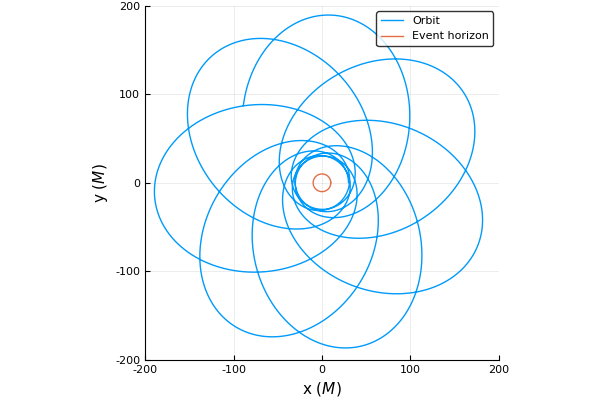

In [11]:
T  = τspan[2]
ts = linspace(0, τspan[2], N*T)

plot(sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*cos.(sol(ts, idxs=4)), 
    sol(ts, idxs=2).*sin.(sol(ts, idxs=3)).*sin.(sol(ts, idxs=4)), 
    aspect_ratio=1, label="Orbit")
ϕ = linspace(0, 2π, 1000)
plot!(2M*cos.(ϕ), 2M*sin.(ϕ), label="Event horizon", xlims=(-200, 200), ylims=(-200, 200))
xlabel!("x (\$M\$)")
ylabel!("y (\$M\$)")

And now for some fun: use the Kerr metric and plot some random trajectories!

In [12]:
a = .8M

kerrmetric = KerrNewmanMetric(M, a, 0)
problem = DirectGeodesicProblem(scmetric)

init_u1 = [0.0, 0.005, 0.02];
init_u2 = [0.0, 0.003, 0.025];
init_u3 = [0.0, 0.008, 0.015];

τspan      = (0.0, 800.0)
diffeq1, X01 = scaffold(problem, init_x, init_u1, τspan)
diffeq2, X02 = scaffold(problem, init_x, init_u2, τspan)
diffeq3, X03 = scaffold(problem, init_x, init_u3, τspan)

sol1 = solve(diffeq1, reltol=1e-8)
sol2 = solve(diffeq2, reltol=1e-8)
sol3 = solve(diffeq3, reltol=1e-8)

retcode: DtLessThanMin
Interpolation: 3rd order Hermite
t: 6421-element Array{Float64,1}:
   0.0      
   0.0797801
   0.839678 
   5.51758  
  13.3673   
  22.6109   
  33.1113   
  44.7736   
  57.4989   
  71.1898   
  84.2837   
  96.5662   
 108.12     
   ⋮        
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
 144.291    
u: 6421-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.37483, 0.0, 0.008, 0.015]                               
 [0.109684, 30.0, 1.57143, 0.0011967, 1.37483, -9.73761e-5, 0.008, 0.015]           
 [1.15441, 29.9996, 1.57751, 0.0125954, 1.37484, -0.00102488, 0.00799991, 0.0150008]
 [7.5865, 29.9814, 1.61493, 0.0828247, 1.37525, -0.00673729, 0.00799618, 0.0150332] 
 [18.3889, 29.8908, 1.67763, 0.201382, 1.37734, -0.0163554, 0.00797691, 0.0151964]  
 [31.1405, 29.6869, 1.75117, 0.343424, 1.38212, -0.0277936, 0.00792928, 0.0155707]  
 [45.6958, 29.3258,

Using Plotly, let's show the orbits in an interactive environment!

In [14]:
plotly();

plot3d(sol1[2, :].*sin.(sol1[3, :]).*cos.(sol1[4, :]),
    sol1[2, :].*sin.(sol1[3, :]).*sin.(sol1[4, :]),
    sol1[2, :].*cos.(sol1[3, :]), label="Orbit 1")

plot3d!(sol2[2, :].*sin.(sol2[3, :]).*cos.(sol2[4, :]),
    sol2[2, :].*sin.(sol2[3, :]).*sin.(sol2[4, :]),
    sol2[2, :].*cos.(sol2[3, :]), label="Orbit 2")

plot3d!(sol3[2, :].*sin.(sol3[3, :]).*cos.(sol3[4, :]),
    sol3[2, :].*sin.(sol3[3, :]).*sin.(sol3[4, :]),
    sol3[2, :].*cos.(sol3[3, :]), label="Orbit 3")

xlabel!("x (\$M\$)")
ylabel!("y (\$M\$)")

What happens if we put give the Kerr metric the same initial conditions as the ISCO for a massive particle around a static black hole?

In [15]:
pyplot();
init_x = [0.0, 6.0M, π/2, 0.0];

l = M*√12
init_u = [0.0, 0.0, l / evaluate(kerrmetric, init_x)[1][4, 4]];

τspan      = (0.0, 400.0)
diffeq, X0 = scaffold(problem, init_x, init_u, τspan)

ε = killing_e(kerrmetric, init_x, X0[5:8])

# Run
sol = solve(diffeq, reltol=1e-10, dense=true, save=true)

retcode: DtLessThanMin
Interpolation: 3rd order Hermite
t: 233957-element Array{Float64,1}:
   0.0     
   0.139583
   0.73649 
   2.89132 
  11.3133  
  40.6623  
  81.8347  
 124.515   
 169.192   
 208.4     
 232.664   
 248.614   
 258.729   
   ⋮       
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
 275.021   
u: 233957-element Array{Array{Float64,1},1}:
 [0.0, 30.0, 1.5708, 0.0, 1.4061, 0.0, 0.0, 0.0187994]                               
 [0.196267, 30.0, 1.5708, 0.00262407, 1.4061, -3.54956e-5, 1.51033e-21, 0.0187994]   
 [1.03558, 29.9999, 1.5708, 0.0138456, 1.4061, -0.000187288, 7.96907e-21, 0.0187995] 
 [4.06551, 29.9989, 1.5708, 0.0543564, 1.40612, -0.000735274, 3.12879e-20, 0.0188007]
 [15.9091, 29.9837, 1.5708, 0.212761, 1.40648, -0.00287799, 1.22591e-19, 0.0188198]  
 [57.2424, 29.7893, 1.5708, 0.768025, 1.41109, -0.0103912, 4.48325e-19, 0.0190663]   
 [115.63, 29.1392, 1.5708, 1.56851,

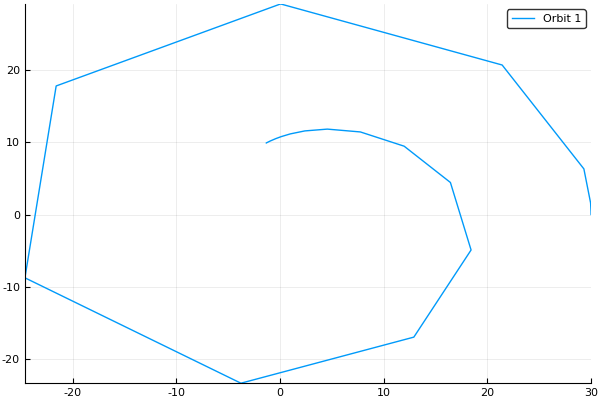

In [17]:
plot(sol[2, :].*sin.(sol[3, :]).*cos.(sol[4, :]),
    sol[2, :].*sin.(sol[3, :]).*sin.(sol[4, :]), label="Orbit 1")

The ISCO is no longer stable! The particle spirals in.